# Transfer  Learning with TensorFlow Part-1: Feature Extraction

Trnsfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefit of Transfer learning:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
# Are we using GPU?
!nvidia-smi

Sun Jun 13 09:49:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and become one with data


In [2]:
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the dowloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-06-13 09:49:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c02::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   183MB/s    in 0.9s    

2021-06-13 09:49:40 (183 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

## Creating data loader (preparing the data) 

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Train Images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing Images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Train Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback.
* Model checkpoint with the ModelCheckpoint callback.
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback.

In [5]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + "experiment_name" + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

Link for [TensorFlow Hub](https://tfhub.dev/).

In [6]:
# Lets compare the following two models:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [7]:
# Imprt dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [8]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and dense output layer with num_classes output neurons.    
  """
  # Download the pre trained model and saves it as keras model
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extractor_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) 
  # Create the model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
  return model

### Creating and Testing ResNet TensorFlow Hub feature Extraction model

In [9]:
# Create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)
                            

In [10]:
# Compile the model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [11]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/experiment_name/20210613-094953
Epoch 1/5
24/24 [==============================] - 51s 755ms/step - loss: 1.9074 - accuracy: 0.3667 - val_loss: 1.2023 - val_accuracy: 0.6348
Epoch 2/5
24/24 [==============================] - 15s 636ms/step - loss: 0.9037 - accuracy: 0.7320 - val_loss: 0.8556 - val_accuracy: 0.7388
Epoch 3/5
24/24 [==============================] - 15s 636ms/step - loss: 0.6089 - accuracy: 0.8440 - val_loss: 0.7518 - val_accuracy: 0.7664
Epoch 4/5
24/24 [==============================] - 15s 642ms/step - loss: 0.4686 - accuracy: 0.8880 - val_loss: 0.7102 - val_accuracy: 0.7720
Epoch 5/5
24/24 [==============================] - 15s 641ms/step - loss: 0.3826 - accuracy: 0.9093 - val_loss: 0.6838 - val_accuracy: 0.7776


In [15]:
 # Let's create a function to plot our loss curves....
 import matplotlib.pyplot as plt

 # PLot the validation and training curves
 def plot_loss_curves(history):
   """
   Returns seperate loss curves for training and validation metrics.

   Args:
    history: TensorFlow history object.

   Returns:
    Plots of training/validation loss and accuracy metrics.
   """
   loss = history.history["loss"]
   val_loss = history.history["val_loss"]

   accuracy = history.history["accuracy"]
   val_accuracy = history.history["val_accuracy"]

   epochs =  range(len(history.history["loss"]))

   # Plot loss
   plt.plot(epochs, loss, label="training_loss")
   plt.plot(epochs, val_loss, label="val_loss")
   plt.title("Loss")
   plt.xlabel("Epochs")
   plt.legend();

   # Plot accuracy
   plt.figure()
   plt.plot(epochs, accuracy, label="training_accuracy")
   plt.plot(epochs, val_accuracy, label="val_accuracy")
   plt.title("Accuracy")
   plt.xlabel("Epochs")
   plt.legend();

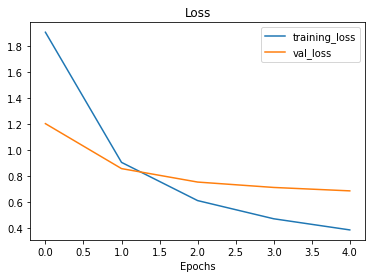

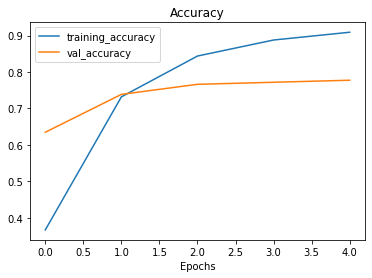

In [17]:
# Check out the loss curves of model_9
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [21]:
# Create EfficientNetB0 feature extraction model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile Efficient model
efficientnet_model.compile(loss="categorical_crossentropy",
                         optimizer=tf.keras.optimizers.Adam(),
                         metrics=["accuracy"])

EPOCHS = 5

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=EPOCHS,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/experiment_name/20210613-104843
Epoch 1/5
24/24 [==============================] - 25s 761ms/step - loss: 1.8529 - accuracy: 0.4293 - val_loss: 1.3071 - val_accuracy: 0.7252
Epoch 2/5
24/24 [==============================] - 14s 618ms/step - loss: 1.0546 - accuracy: 0.7907 - val_loss: 0.8714 - val_accuracy: 0.8176
Epoch 3/5
24/24 [==============================] - 14s 622ms/step - loss: 0.7460 - accuracy: 0.8400 - val_loss: 0.7046 - val_accuracy: 0.8396
Epoch 4/5
24/24 [==============================] - 14s 618ms/step - loss: 0.6052 - accuracy: 0.8693 - val_loss: 0.6171 - val_accuracy: 0.8544
Epoch 5/5
24/24 [==============================] - 15s 627ms/step - loss: 0.5105 - accuracy: 0.8920 - val_loss: 0.5628 - val_accuracy: 0.8576


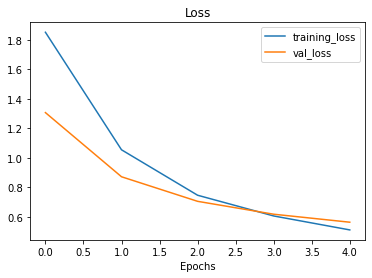

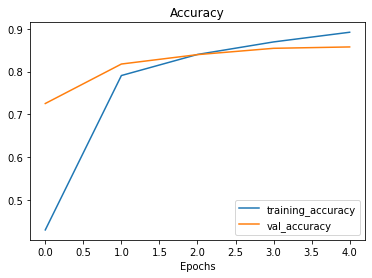

In [22]:
plot_loss_curves(efficientnet_history)

In [23]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [24]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [27]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g. using ImageNet model on 1000 ImageNet classes, None of your own).
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food).
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers).

## Comparing oour models results using TensorBoard

> **Note:** When you upload things to TensorBoard.dev, you experiments are public. So if you're running private experiments (things you dont want others to see) do not upload them to TensorBoard.dev.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
   --name "EfficientNetB0 vs. ResNet50V2" \
   --description "Comparing two different TF hub feature extraction model architectures using 10% of the training data" \
   --one_shot 

Our TensorBoard experiments are uploaded publically here : https://tensorboard.dev/experiment/jJFZ7X1LQAasAQwbsaBJzQ/

In [35]:
# Check out what TensorBoard experiments we have
!tensorboard dev list

2021-06-13 11:43:03.742058: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/jJFZ7X1LQAasAQwbsaBJzQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF hub feature extraction model architectures using 10% of the training data
	Id                   jJFZ7X1LQAasAQwbsaBJzQ
	Created              2021-06-13 11:25:53 (17 minutes ago)
	Updated              2021-06-13 11:25:55 (17 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5960471
Total: 1 experiment(s)
